## Spain Energy Analysis 
To make the successful transition to renewable energy, forecasting is commonly used in the energy markets to understand energy demand as well as energy generation under certain weather or seasonal trend. The use of machine learning on time series datasets is highly leveraged to understand these dynamics. 

The goal of this analysis is to practice data preprocessing, implement algorithms on time series dataset, and evaluate models using different metrics. The previous notebook prepares the dataset, consolidating and interpolating columns. We will still go through the data cleaning process briefly here. This notebook presents the process of exploring the energy dataset and preprare for building time series forecasting models. 

In [ ]:
# data analysis, wrangling and preprocessing
import numpy as np 
import pandas as pd
import datetime

# data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotnine import ggplot
import plotly.express as px
plt.style.use('fivethirtyeight') # change the style of the plot

# time series analysis
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import signal

# missing data interpolation
from scipy.interpolate import CubicSpline

# preprocessing 
from sklearn.preprocessing import OneHotEncoder

# time series forecasting 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

### Loading data 
We start by loading the dataset into Pandas DataFrames.

In [ ]:
energy = pd.read_csv('energy_dataset.csv')
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


Using the `info` function to check if there is any missing values in this dataset as well the data type for each column.

In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

Some takeaways from the output above:
* There are two columns (`generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'`) that don't have any values in them. We will drop these two columns. We will also drop the columns that are not useful to our analysis (`total load forecast`, `forecast solar day ahead`, `forecast wind onshore day ahead`, `price day ahead`).
* There might be some missing values for some of the columns. We will try to check the missing rate and decide how to deal with them.
* We will rename the column names because columns name are long and not necessary.

Drop the uninformative columns

In [ ]:
energy.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead',
'total load forecast','forecast solar day ahead','forecast wind onshore day ahead','price day ahead'], axis=1, inplace=True)

Find the missing rate for each column

In [ ]:
energy.isnull().mean()

time                                           0.000000
generation biomass                             0.000542
generation fossil brown coal/lignite           0.000513
generation fossil coal-derived gas             0.000513
generation fossil gas                          0.000513
generation fossil hard coal                    0.000513
generation fossil oil                          0.000542
generation fossil oil shale                    0.000513
generation fossil peat                         0.000513
generation geothermal                          0.000513
generation hydro pumped storage consumption    0.000542
generation hydro run-of-river and poundage     0.000542
generation hydro water reservoir               0.000513
generation marine                              0.000542
generation nuclear                             0.000485
generation other                               0.000513
generation other renewable                     0.000513
generation solar                               0

All of the columns that have a missing data have the missing rate of less than 1%. We will conduct a missingness analysis to see if those missing values are coming from a specific period of time. 

#### Rename columns
We drop the unnecessary text in the column names and rename `total load actual` to `energy demand`.

In [ ]:
energy.rename(columns=lambda x: x[11:] if 'generation' in x else x, inplace=True)
energy.rename(columns={'total load actual':'energy demand'}, inplace=True)

#### Create different time granularity
To explore the dataset further, we create a `Year` and `Year-Month` column for later aggregation purposes.

In [ ]:
energy['time'] = pd.to_datetime(energy['time'], utc=True)
energy['Year'] = energy['time'].dt.year
energy['Year-Month'] = pd.to_datetime(energy['time'].dt.strftime('%Y-%m-01')).dt.date

In [ ]:
energy['Year-Month'].head()

0    2014-12-01
1    2015-01-01
2    2015-01-01
3    2015-01-01
4    2015-01-01
Name: Year-Month, dtype: object

### Missingness analysis
Even though the missing rate is less than 1% of the time, we still try to see if they all come from a specific period.

In [ ]:
energy[energy.isna().any(axis=1)]

,time,biomass,fossil brown coal/lignite,fossil coal-derived gas,fossil gas,fossil hard coal,fossil oil,fossil oil shale,fossil peat,geothermal,...,other,other renewable,solar,waste,wind offshore,wind onshore,energy demand,price actual,Year,Year-Month
99,2015-01-05 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21182.0,59.68,2015,2015-01-01
108,2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.14,2015,2015-01-01
109,2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.95,2015,2015-01-01
110,2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.93,2015,2015-01-01
111,2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.50,2015,2015-01-01
112,2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.85,2015,2015-01-01
113,2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.53,2015,2015-01-01
451,2015-01-19 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,39304.0,88.95,2015,2015-01-01
452,2015-01-19 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,39262.0,87.94,2015,2015-01-01
643,2015-01-27 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,38335.0,83.97,2015,2015-01-01


There are only 47 records that contain NaN in the row. We want to plot these 47 records on a timeline and see if there are any clusters.

Text(0.5, 1.0, 'NAN values across time')

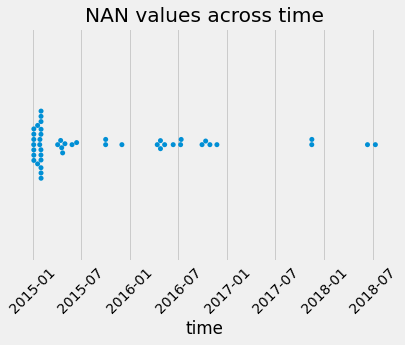

In [ ]:
sns.swarmplot(x='time', data=energy[energy.isna().any(axis=1)])
plt.xticks(rotation=45)
plt.title('NAN values across time')

In [ ]:
energy[energy.isna().any(axis=1)].groupby('Year-Month')['time'].count()

Year-Month
2015-01-01    11
2015-02-01    11
2015-04-01     4
2015-05-01     2
2015-06-01     1
2015-10-01     2
2015-12-01     1
2016-04-01     3
2016-05-01     1
2016-06-01     1
2016-07-01     2
2016-09-01     1
2016-10-01     2
2016-11-01     1
2017-11-01     2
2018-06-01     1
2018-07-01     1
Name: time, dtype: int64

As we can see in the timeline of the events and frenquency of NaN values by month table above, they scattered around since the data are being recorded. There are several clusters early on, such as the one around January 2015 and May 2015. There are fewer and fewer records recently. It is possible that the instruments were being set up to measure those energy generation data early on, They have a more healthy infrastructure in place to collect necessary data.

### Consolidate different energy sources
We want to consolidate the existing columns into the following columns by summing up the related subcolumns for further analysis. Here is a brief description of each columns:
* Fossil fuel as `fossil_fuel`: nonrenewable energy formed in the geological past from the remains of living organisms.
* Energy generated from biomass as `biomass` (renewable energy produced by living or once-living organisms)
* Energy generated from hydropower as `hydro` (renewable energy generated by fast-running water)
* Energy generated from nuclear energy as `nuclear` (nonrenewable energy that use a nuclear reaction to produce electricity)
* Energy generated from wind energy as `wind` (renewable energy that converts kinetic energy in the wind into mechanical power)
* Energy generated from waste as `waste` (Waste-to-energy plants make steam and electricity)
* Energy generated from other sources as `others`

In [ ]:
fossil_fuel = ['fossil brown coal/lignite', 'fossil gas',
       'fossil hard coal', 'fossil oil']
hydro = ['hydro pumped storage consumption',
       'hydro run-of-river and poundage',
       'hydro water reservoir']
wind = ['wind onshore']
others = ['other', 'other renewable'] 
energy['fossil_fuel'] = energy.loc[:, fossil_fuel].sum(axis=1)
energy['hydro'] = energy.loc[:, hydro].sum(axis=1)
energy['wind'] = energy.loc[:, wind].sum(axis=1)
energy['others'] = energy.loc[:, others].sum(axis=1)

We have aggregated there columns:
* `biomass`
* `fossil_fuel`
* `hydro`
* `wind`
* `solar`
* `nuclear`
* `waste`
* `others`

All of them are in Megawatts(MW).

### Find pattern for zero value entry  
We want to see if any zero values in this dataset are meaningful. If not, they can be treated as missing values (NaN) and interpolate together with other NaN values. 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '2015-01-01'),
  Text(1, 0, '2015-04-01'),
  Text(2, 0, '2015-06-01'),
  Text(3, 0, '2015-10-01'),
  Text(4, 0, '2015-12-01'),
  Text(5, 0, '2016-07-01'),
  Text(6, 0, '2017-11-01'),
  Text(7, 0, '2018-05-01'),
  Text(8, 0, '2018-07-01')])

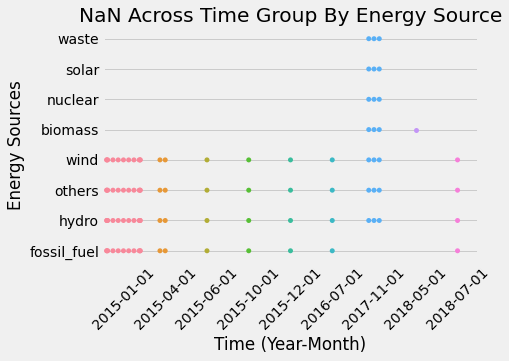

In [ ]:
energy_list = ['biomass','fossil_fuel','hydro','wind','solar','nuclear','waste','others']
energy_flat = pd.melt(energy, id_vars='Year-Month', value_vars=energy_list)
tmp = energy_flat.loc[energy_flat.value == 0]
tmp.sort_values(by='Year-Month', inplace=True)
sns.swarmplot(x='Year-Month', y='variable', data=tmp)
plt.title('NaN Across Time Group By Energy Source')
plt.ylabel('Energy Sources')
plt.xlabel('Time (Year-Month)')
plt.xticks(rotation=45)

According to the plot above, we can see that zero values coincide between different energy sources. Since they are sparse eariler in time, we can view them as missing values assume there are no large energy storage facilities. That is, there was energy being generated, but was not recorded in this dataset. As a result, we can replace all the zero values with NaN and interpolate them with all the other NaN values. 

In [ ]:
energy[energy_list] = energy[energy_list].replace(['0', 0], np.nan)

### Interpolation
We use two different methods to interpolate all the NaN values that we in the `energy` dataset. 
* If there are multiple NaN values in the close span, we use quadratic interpolation with the order of four to account for the movement of the curve. 
* If there is only one NaN value in the close span, we use CubicSpline method to interpolate that specific NaN value.

We wrote a function below to automate this process.

In [ ]:
def interpolation(column_list, energy):
    for column in column_list:
        index_list = energy[energy[column].isna()].index
        for index in index_list:
            lb = index - 10
            up = index + 10
            if ((energy.iloc[lb:up][column].isna()).sum() > 1):
                temp = energy.iloc[lb:up][column]
                # temp = temp[temp != 0]
                indices = temp[temp.isna()].index
                temp = temp.interpolate(method='quadratic', order=4)
                # temp[temp == 0] = np.nan
                # indices = temp[temp.isna()].index
                for index in indices:
                    energy.loc[index, column] = temp.loc[index]
            else:
                lb = index - 2
                up = index + 2
                temp = energy.iloc[lb: up][column]
                temp = temp[~temp.isna()]
                X = temp.index.values
                y = temp.values
                cs = CubicSpline(X , y)
                energy.loc[index, column] = cs(index).item(0)

Call the function `interpolation` and pass in a list of columns that we want to interpolate and the `energy` dataframe.

In [ ]:
interpolation(energy_list, energy)

We want to make sure there are no NaN or zero values in the `energy` dataframe beofre going into analysis.

In [ ]:
energy.loc[:,energy_list].isna().sum() + energy.loc[:,energy_list][energy.loc[:,energy_list] == 0].sum()

biomass        0.0
fossil_fuel    0.0
hydro          0.0
wind           0.0
solar          0.0
nuclear        0.0
waste          0.0
others         0.0
dtype: float64

There is no row with either zero values or NaN values after interpolation. We can proceed to further analysis.

### Downsampling and Aggregation
Since it's hard to analyze the high-frequency time-series data collected every single hour, we want to downsample them to longer periods, such as days, months, or even years. We use the `resample` function to convert the frequency of this time series of energy across time and aggregate the data for each period.

#### Aggregate Year-over-Year (YoY) Energy Demand 
We want to compare YoY energy demand at the monthly level.

First, we want to clean up the `energy demand` column, including the following things:
* Find all the zero values if there are any zero values
* Deal with the zero values or the NaN values
* Aggregate for the monthly demand across different years

In [ ]:
num_nan = energy[energy['energy demand'].isna()].shape[0]
num_zero = energy[energy['energy demand'] == 0].shape[0]
print(f'There are {num_nan} rows with NA values in the energy demand column and {num_zero} rows with zero values in the energy demand column.')

There are 36 rows with NA values in the energy demand column and 0 rows with zero values in the energy demand column.


Plot the NaN values across time to see if there is a pattern across time. 

Text(0.5, 1.0, 'NAN values across time')

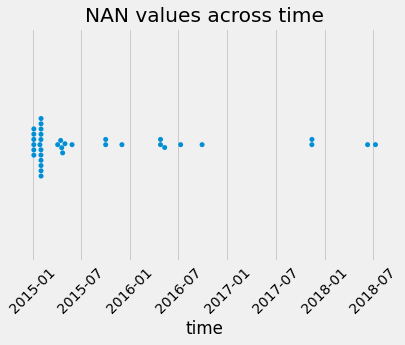

In [ ]:
sns.swarmplot(x='time', data=energy[energy['energy demand'].isna()])
plt.xticks(rotation=45)
plt.title('NAN values across time')

There is no specific pattern on the timeline above except there was a cluster in mid-2015. We can use the interpolation function we created earlier to make sure we have validated values for each entry.

In [ ]:
energy = energy.reset_index()
interpolation(['energy demand'], energy)

We want to look for a pattern in energy demand by comparing YoY energy demand at the monthly level.

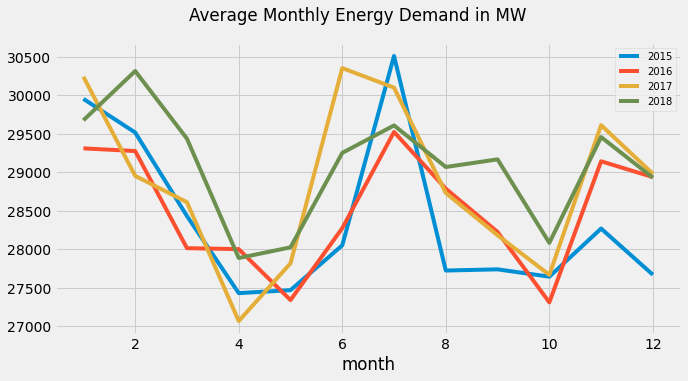

In [ ]:
# drop the one row that's from 2014 because of the timezone
energy = energy[energy['Year'] != 2014]
energy.set_index('time', inplace=True)
index_year = energy.index.year
index_month = energy.index.month
demand_by_month = energy.groupby([index_year, index_month])['energy demand'].mean()
demand_by_month.unstack(level=0).plot(kind='line')
plt.xlabel('month')
plt.suptitle('Average Monthly Energy Demand in MW')
plt.legend(loc='best', prop={'size': 10})
plt.gcf().set_size_inches(10, 5)

We can clearly see some patterns of monthly demand over a 4-year period:
* Peaks at summertime probably due to the widely used air conditioners for cooling 
* Peaks at winter time when air conditioners or other heating equipment are widely used for warming  
* The peak of energy demand in 2017 happened a month early compared to other years
* There was a higher energy demand throughout the year 2018. However, it had relatively low peak demand during the summer of 2018

One of the hypotheses we can make is that weather played an important role in the change in YOY energy demand. 

#### Aggregate energy generation by year
We want to look at the major energy generation on a high level across years to see if there is a major change in the energy sources throughout the time when this data is available.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


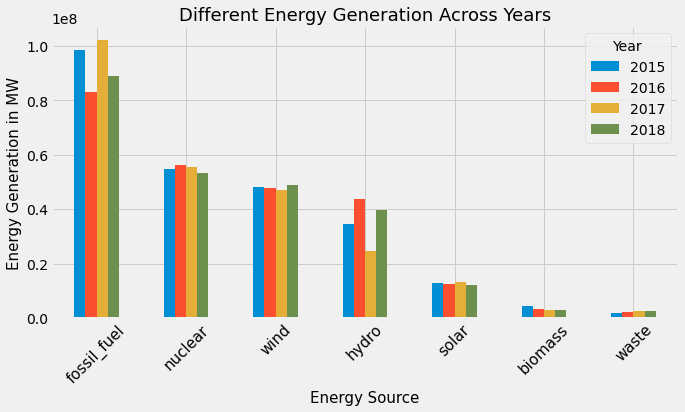

In [ ]:
groupby_year = pd.DataFrame(energy.groupby('Year')['fossil_fuel','nuclear','wind',
'hydro','solar', 'waste','biomass'].sum())  
groupby_year.reset_index('Year', inplace =True)
energy_flat = pd.melt(groupby_year, id_vars='Year', value_vars=['fossil_fuel','nuclear','wind',
'hydro','solar', 'waste','biomass'])
energy_flat.pivot(columns='Year', index='variable', values='value').sort_values(by=2018, ascending=False).plot(kind='bar')
plt.xticks(rotation=45, size=15)
plt.xlabel('Energy Source', size = 15)
plt.ylabel('Energy Generation in MW', size = 15)
plt.title('Different Energy Generation Across Years', size = 18)
plt.gcf().set_size_inches(10, 5)

We can see how major energy sources change across the years and the relative amount of energy generated between each energy source. Here are some takeaways from this plot:
* `nuclear`, `wind`, `biomass`, `wind`, and `waste` stayed at similar a level over the years
* `fossil_fuel` generated the largest proportion of energy across time even though there are some fluctuations between neighboring years
* When there was a decline in the amount of energy being generated by `fossil_fuel`, the level of `hydro` increased to meet the overall energy demand. 

#### Downsample Hourly Energy Generation to Monthly Energy Generation
This helps us to see the trend of the generation of each energy source across different months, from January 2015 to December 2018. We could see some possible correlations between different energy sources as well.

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


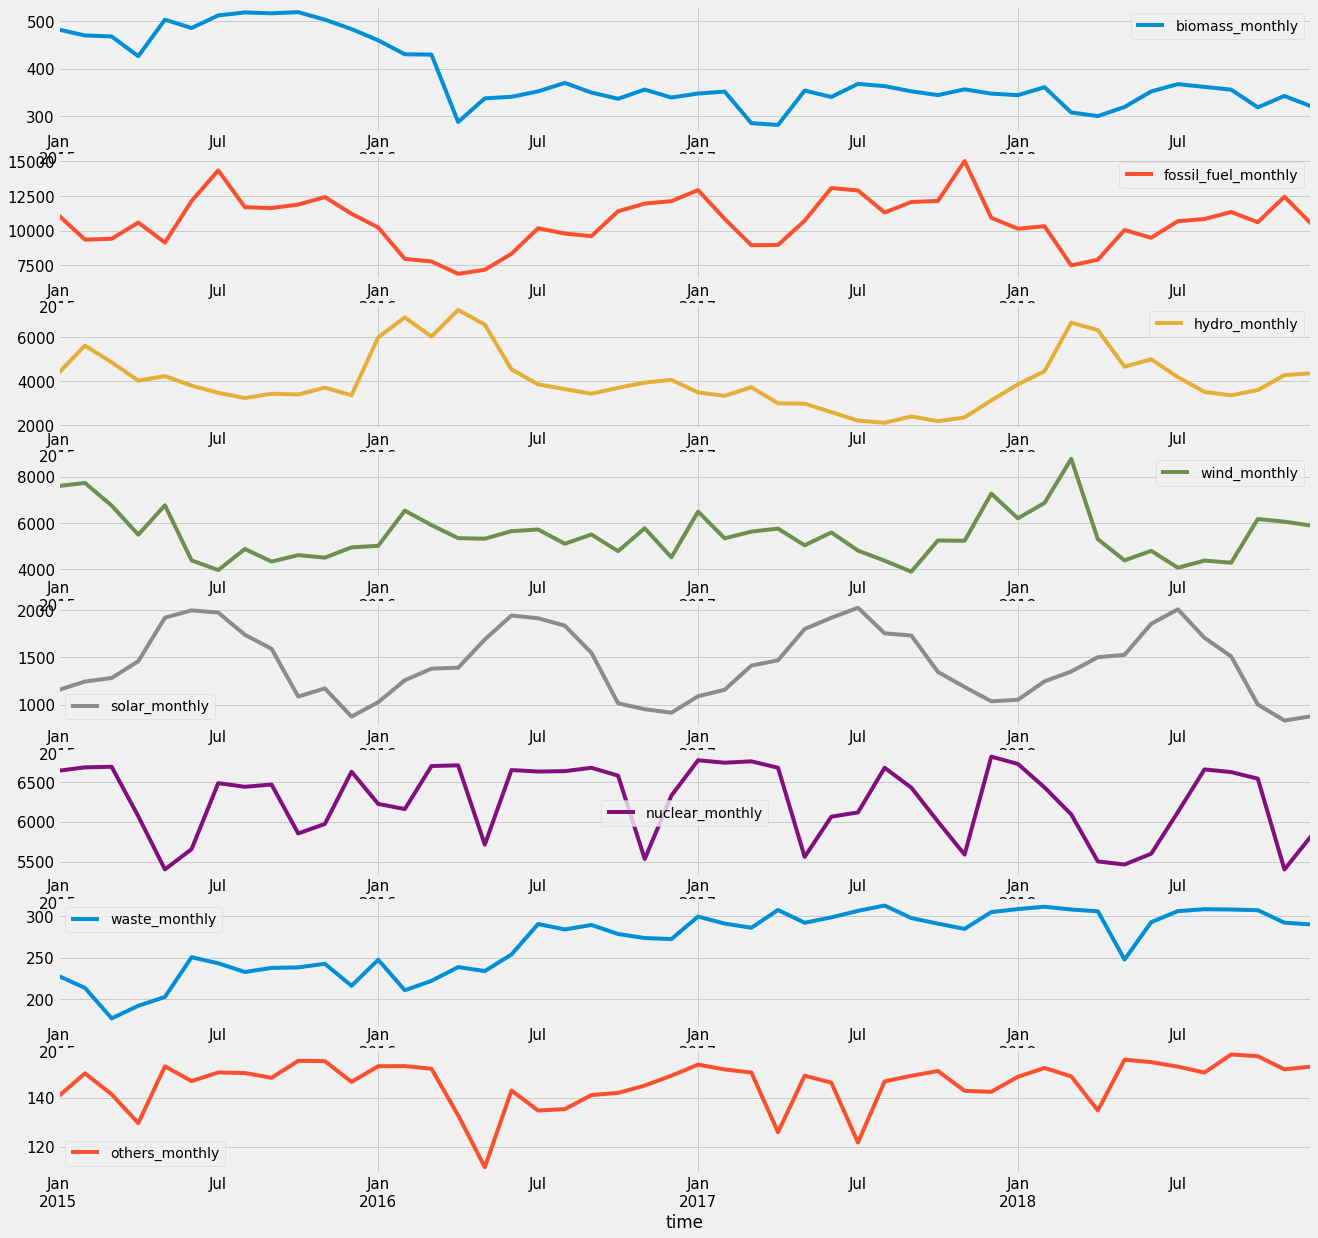

In [ ]:
monthly = energy.resample('M').mean()
ax = energy.loc[:,energy_list].plot()
monthly.loc[:,energy_list].add_suffix('_monthly').plot(ax=ax, subplots=True, fontsize=15)
plt.gcf().set_size_inches(20, 20)

We want to see YoY changes for the energy generated by each energy source across different months.

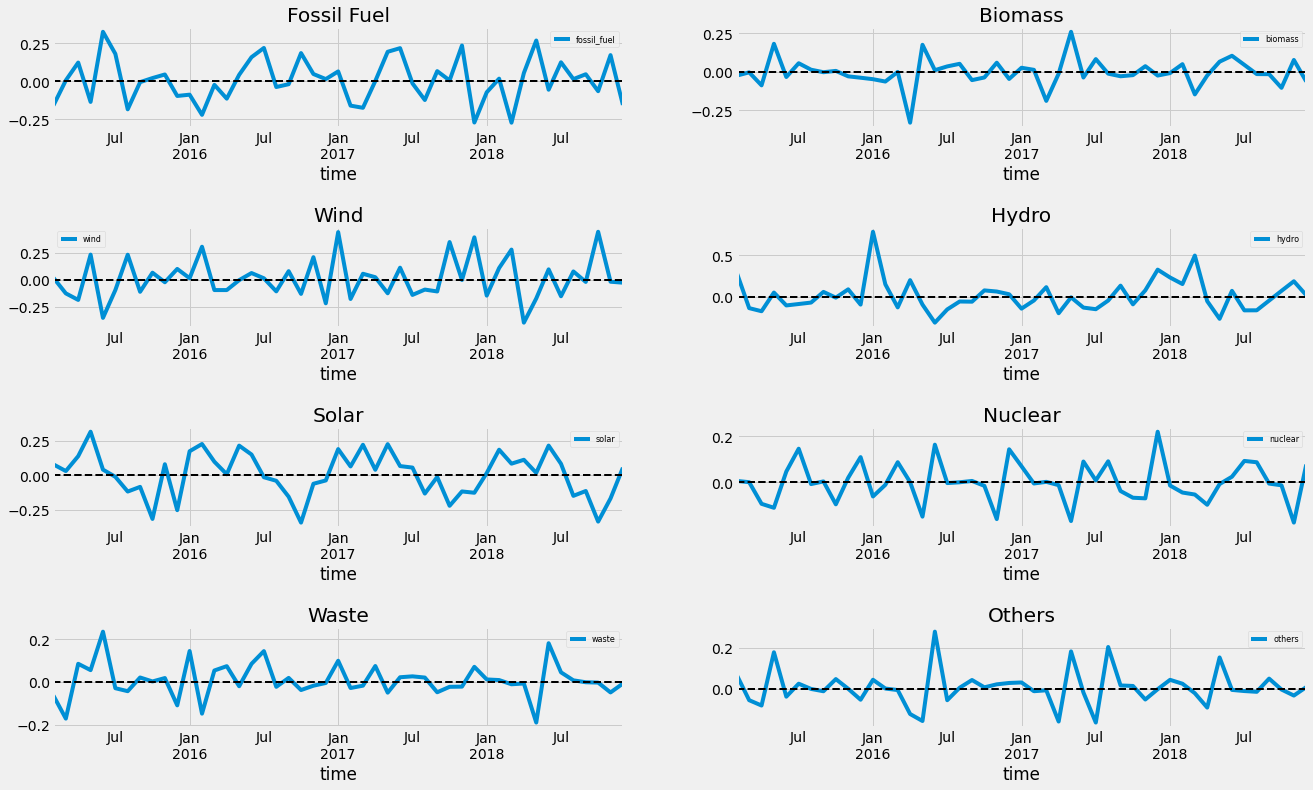

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(20,12))
g_pct_month = monthly.loc[:,energy_list].pct_change().dropna()

g_pct_month['fossil_fuel'].plot(kind='line', ax=axs[0,0])
axs[0,0].set_title('Fossil Fuel')
axs[0,0].legend(loc='best', prop={'size': 8})
axs[0,0].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['biomass'].plot(kind='line', ax=axs[0,1])
axs[0,1].set_title('Biomass')
axs[0,1].legend(loc='best', prop={'size': 8})
axs[0,1].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['wind'].plot(kind='line', ax=axs[1,0])
axs[1,0].set_title('Wind')
axs[1,0].legend(loc='best', prop={'size': 8})
axs[1,0].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['hydro'].plot(kind='line', ax=axs[1,1])
axs[1,1].set_title('Hydro')
axs[1,1].legend(loc='best', prop={'size': 8})
axs[1,1].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['solar'].plot(kind='line', ax=axs[2,0])
axs[2,0].set_title('Solar')
axs[2,0].legend(loc='best', prop={'size': 8})
axs[2,0].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['nuclear'].plot(kind='line', ax=axs[2,1])
axs[2,1].set_title('Nuclear')
axs[2,1].legend(loc='best', prop={'size': 8})
axs[2,1].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['waste'].plot(kind='line', ax=axs[3,0])
axs[3,0].set_title('Waste')
axs[3,0].legend(loc='best', prop={'size': 8})
axs[3,0].axhline(0, linestyle='--', color='k', lw=2)

g_pct_month['others'].plot(kind='line', ax=axs[3,1])
axs[3,1].set_title('Others')
axs[3,1].legend(loc='best', prop={'size': 8})
axs[3,1].axhline(0, linestyle='--', color='k', lw=2)

plt.subplots_adjust(hspace = 1)

#### Time Series Decomposition
We think of each time series as a combination of three components: trend, seasonality, and noise. We plot the time series decomposition of each major energy source to better understand each time series. We investigate these time series based on the scale of energy generation, from the highest to the lowest.

##### `fossil_fuel` decomposition
We decompose the `fossil_fuel` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

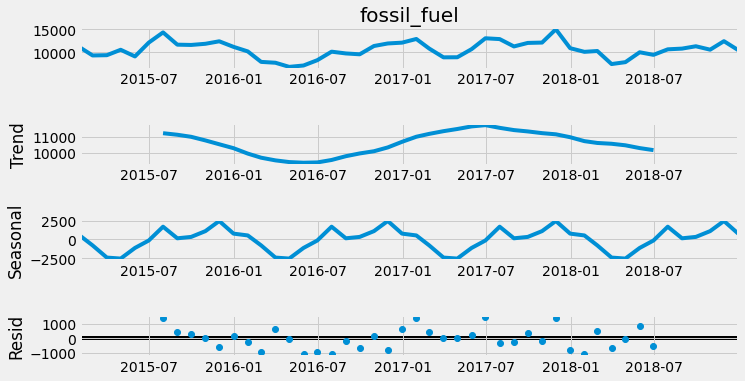

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['fossil_fuel'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

We can see from the plot above, the level of the energy generation of fossil fuels was stable at around 10,000 MW over the years with some ups and downs. The seasonality is consistent across these 4-year period as well with two peaks around July and December each year.

Fossil fuels are readily available and relatively easy to produce energy compare to other energy sources, however, it's a nonrenewable energy source and releases greenhouse gas to the atmosphere. In order to reduce the reliance on fossil fuels, we can identify the peak of the seasonality component of this time series and see what are some alternatives to meet the peak energy demand.

##### `nuclear` decomposition
We decompose the `nuclear` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

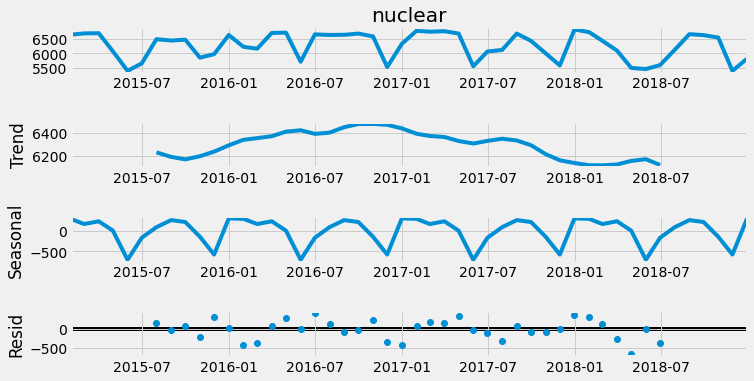

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['nuclear'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

We can see from the plot above, there was an increase in the amount of energy produced during 2016 followed by a decrease in the following years. The seasonality is consistent across these 4-year periods with the peak in January and October and trough in June.

It's interesting to see that fossil fuels accounted for the majority of energy production when the energy generation for nuclear is down in December. Renewable energy sources, like geothermal, could be explored to generate some of the energy needs during the wintertime, especially for heating purposes. Also, the geothermal column was all zero in this dataset, which provides great potential.

Unlike fossil fuels, nuclear energy does not produce greenhouse gas emissions. However, there is always a risk for the potential meltdown of the nuclear plant despite all the safety measures. Nuclear power has the potential to produce energy consistently on a large scale. 

##### `wind` decomposition
We decompose the `wind` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

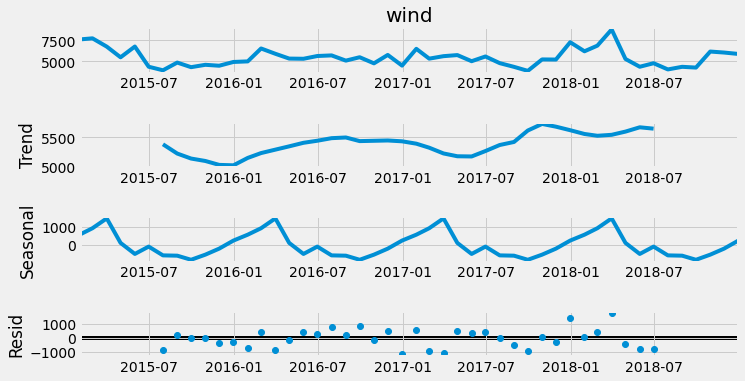

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['wind'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

##### `hydro` decomposition
We decompose the `hydro` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

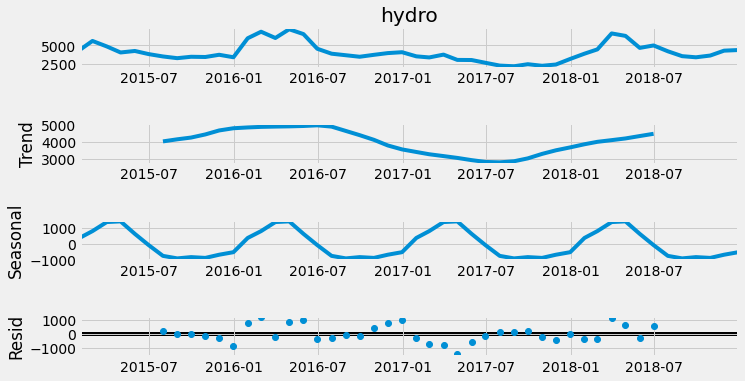

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['hydro'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

##### `solar` decomposition
We decompose the `solar` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

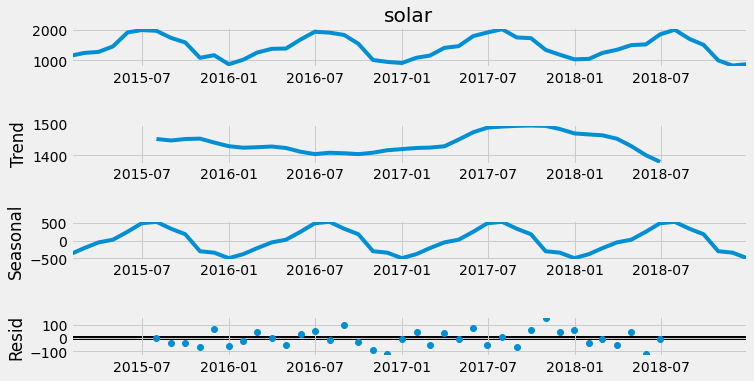

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['solar'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

##### `waste` decomposition
We decompose the `waste` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

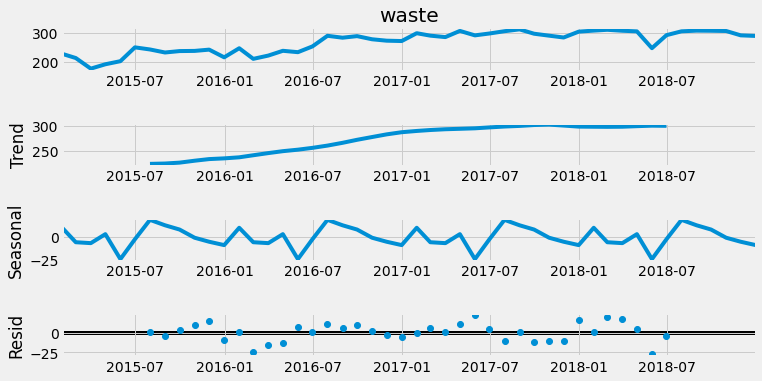

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['waste'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

##### `biomass` decomposition
We decompose the `biomass` column into its major components, including trend, seasonlity, and noise. We plot the time series itself as well as the major components.

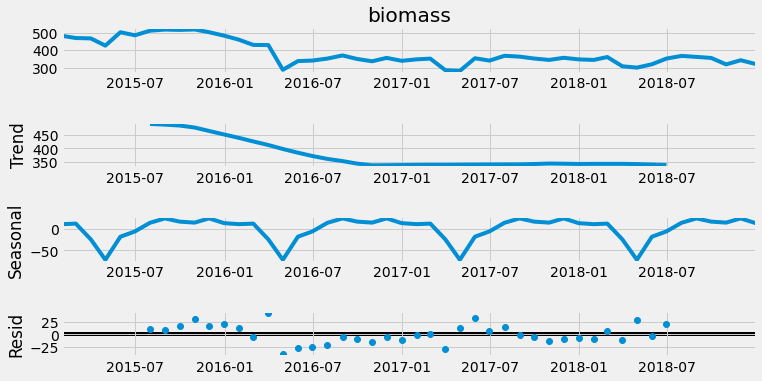

In [ ]:
decomposition = sm.tsa.seasonal_decompose(monthly.loc[:,energy_list]['biomass'])
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 6)

#### Trend component (monthly rolling average)
We use the rolling average plot to distinguish the scale between major energy sources.

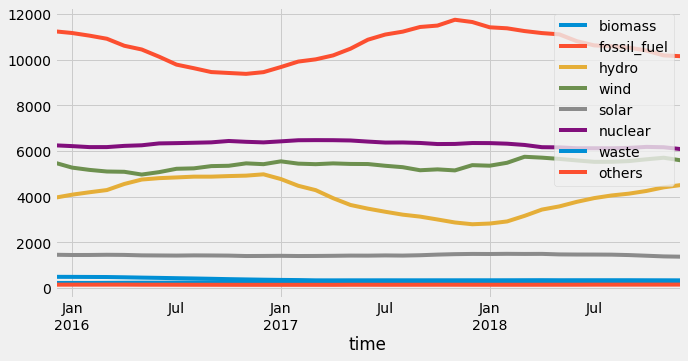

In [ ]:
monthly.loc[:,energy_list].rolling(window=12).mean().dropna().plot()
plt.gcf().set_size_inches(10, 5)
plt.legend(energy_list, loc='best')

We can get the general trend of the generation of each major energy source. One thing to note is that each energy source is plotted on the same scale just to compare the overall trends. Here are some key takeaways from this plot:
* There is a general trend of the `solar` because of the location of Spain and its seasonality. Since Spain locates in the northern hemisphere, it has summer around June and winter around November. The plot clearly shows that the amount of energy being generated by `solar` peaks every year around July and has its lows around wintertime. 
* Energy production by `nuclear` tends to increase during the time when the amount of energy produced by `solar` experiences its low points.
* `nuclear` has its low every now and then probably because of the inspection routinely that decreases the energy production.
* The two peaks of `fossil_fuel` correspond to the two troughs of `hydro`. 
* The peaks of `hydro` overlap with peaks of `wind`.

#### Visusalization Correlations Between Energy Sources
We use a heapmap to visualize the correlation bewteen each series of major energy source.

(array([], dtype=float64), [])

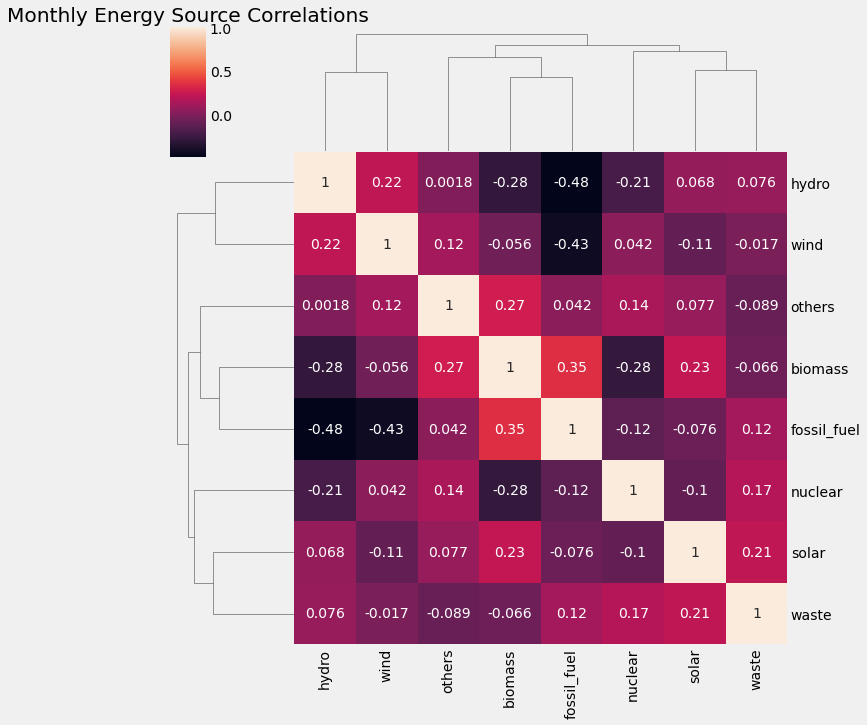

In [ ]:
monthly_changes = energy.loc[:,energy_list].resample('M').mean().pct_change()
sns.clustermap(monthly_changes.corr(), annot=True)
plt.title('Monthly Energy Source Correlations')
plt.xticks(rotation=45)

We can get a lot of information from the heatmap above. We will focus on talking about the energy sources that account for the major source of energy generation: `fossil_fuel`, `nuclear`, `wind`, `hydro`, and `solar`.

Based on this heatmap, `fossil_fuel` (nonrenewable) seems to have a negative correlation with other renewable energy sources, including `nuclear`, `wind`, `hydro`, and `solar`. It has a strong negative correlation with `hydro` and `wind`. We can see that renewable and nonrenewable energy sources complement each other to meet the overall demand from consumers.

### Autocorrelation of Energy Generation
We have to determine whether this major energy generation is stationary before plotting them in Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) and starting to model them. First, we run **Augmented Dickey-Fuller (ADF)** test:

Making sure that each individual energy source is stationary by running the ADF test for each major energy source with the following:
* Null hypothesis (H0): the data needs to be differenced to make it stationary
* Alternative hypothesis (H1): the data is stationary and doesn’t need to be differenced

If any of them are not stationary, we can plot ACF and PACF to determine what's the optimal order of differencing. 

In [ ]:
aDict = {}
def adf(column_list):
    for column in column_list:
        result = adfuller(energy[column], autolag='AIC')
        if result[1] < 0.05:
            print(f'Reject null hypothesis, {column} is stationary')
        else:
            print(f'Fail to reject null hypothesis, {column} needs to be differenced')
        aDict[column] = [round(result[0], 5), result[1]]

In [ ]:
adf(energy_list)

Reject null hypothesis, biomass is stationary
Reject null hypothesis, fossil_fuel is stationary
Reject null hypothesis, hydro is stationary
Reject null hypothesis, wind is stationary
Reject null hypothesis, solar is stationary
Reject null hypothesis, nuclear is stationary
Reject null hypothesis, waste is stationary
Reject null hypothesis, others is stationary


In [ ]:
df = pd.DataFrame(aDict)
df = df.transpose()
df.columns = ['ADF Statistic', 'p-value']
df

,ADF Statistic,p-value
biomass,-7.67289,1.576430e-11
fossil_fuel,-15.48372,2.536724e-28
hydro,-10.88681,1.253985e-19
wind,-17.96120,2.816536e-30
solar,-13.89658,5.836781e-26
nuclear,-12.62526,1.546623e-23
waste,-9.21629,1.830068e-15
others,-14.24770,1.499580e-26


We ran the Dickey-Fuller test through all the major energy sources. All of the time series of the energy sources are stationary from the output of the `adfuller` function, ADF statistic, and p-value.

Next, we plot Autocorrelation Function (ACF) to have a better understanding of each energy generation series.

Text(0.5, 1.0, 'Others')

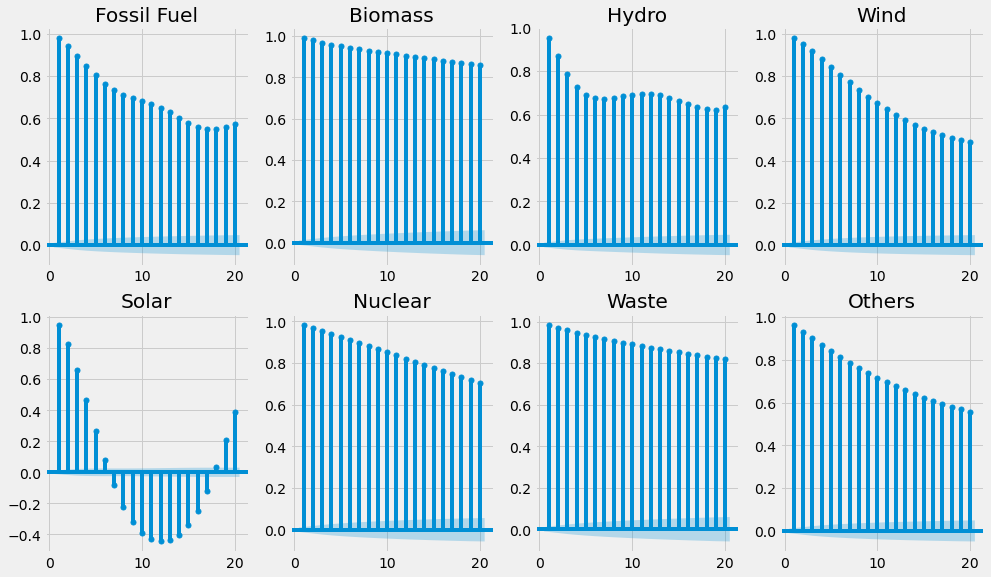

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15,9))

x = plot_acf(energy['fossil_fuel'], alpha=0.05, lags=20, zero=False, ax = axs[0,0])
axs[0,0].set_title('Fossil Fuel')

x = plot_acf(energy['biomass'], alpha=0.05, lags=20, zero=False, ax = axs[0,1])
axs[0,1].set_title('Biomass')

x = plot_acf(energy['hydro'], alpha=0.05, lags=20, zero=False, ax = axs[0,2])
axs[0,2].set_title('Hydro')

x = plot_acf(energy['wind'], alpha=0.05, lags=20, zero=False, ax = axs[0,3])
axs[0,3].set_title('Wind')

x = plot_acf(energy['solar'], alpha=0.05, lags=20, zero=False, ax = axs[1,0])
axs[1,0].set_title('Solar')

x = plot_acf(energy['nuclear'], alpha=0.05, lags=20, zero=False, ax = axs[1,1])
axs[1,1].set_title('Nuclear')

x = plot_acf(energy['waste'], alpha=0.05, lags=20, zero=False, ax = axs[1,2])
axs[1,2].set_title('Waste')

x = plot_acf(energy['others'], alpha=0.05, lags=20, zero=False, ax = axs[1,3])
axs[1,3].set_title('Others')

Then, we plot Partial Autocorrelation Function (PACF) to have a better understanding of each energy generation series.

Text(0.5, 1.0, 'Others')

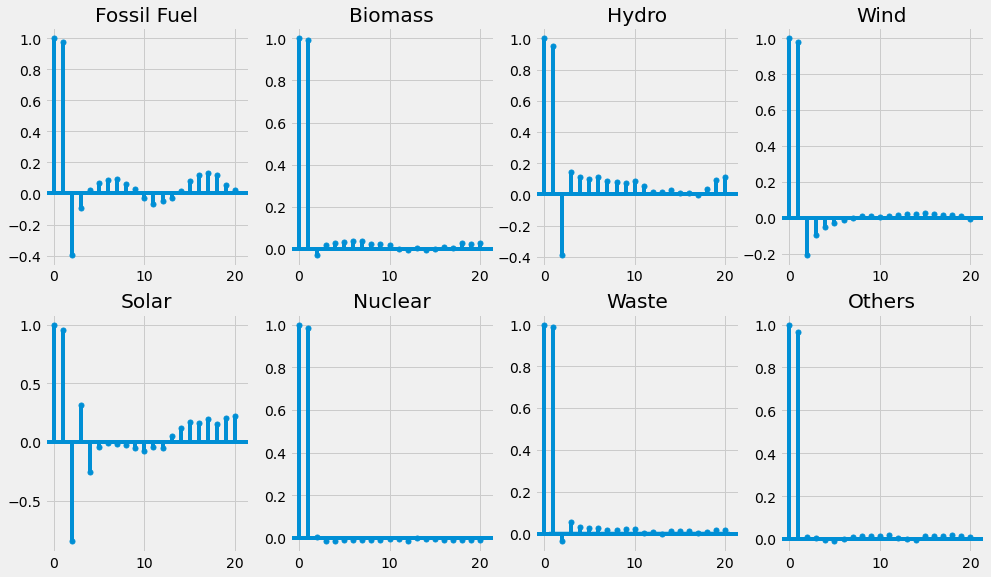

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15,9))

x = plot_pacf(energy['fossil_fuel'], alpha=0.05, lags=20, ax = axs[0,0])
axs[0,0].set_title('Fossil Fuel')
 
x = plot_pacf(energy['biomass'], alpha=0.05, lags=20, ax = axs[0,1])
axs[0,1].set_title('Biomass')

x = plot_pacf(energy['hydro'], alpha=0.05, lags=20, ax = axs[0,2])
axs[0,2].set_title('Hydro')

x = plot_pacf(energy['wind'], alpha=0.05, lags=20, ax = axs[0,3])
axs[0,3].set_title('Wind')

x = plot_pacf(energy['solar'], alpha=0.05, lags=20, ax = axs[1,0])
axs[1,0].set_title('Solar')

x = plot_pacf(energy['nuclear'], alpha=0.05, lags=20, ax = axs[1,1])
axs[1,1].set_title('Nuclear')

x = plot_pacf(energy['waste'], alpha=0.05, lags=20, ax = axs[1,2])
axs[1,2].set_title('Waste')

x = plot_pacf(energy['others'], alpha=0.05, lags=20, ax = axs[1,3])
axs[1,3].set_title('Others')

### Bivariate Analysis for Columns
We expect there are some relationships between certain columns. For example, more energy demand may correspond to higher energy generation or higher demand may cause the energy price to increase. 

#### Compare energy generation to demand
We want to see how the demand compared to the actual energy generation. We are able to get more insights into the energy operation. For example, we will be able to know how the energy operation reacts to a surge in demand. There could be large-scale energy storage facilities or some of the energy is used as backups to ensure that the demand is met.

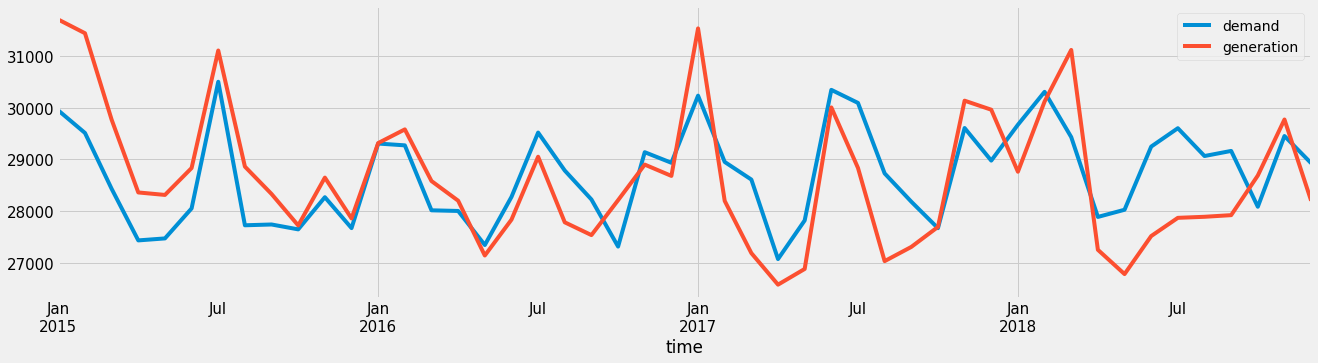

In [ ]:
energy['energy generation'] = energy.loc[:, energy_list].sum(axis=1)
monthly_demand = energy.resample('M').mean()
monthly_demand['energy demand'].plot(fontsize=15, label='demand')
monthly_demand['energy generation'].plot(fontsize=15, label='generation')
plt.gcf().set_size_inches(20, 5)
plt.legend()

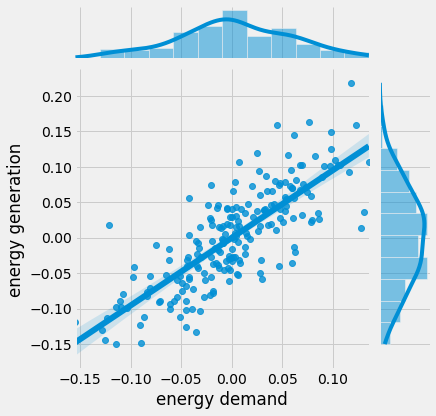

In [ ]:
weekly_demand = energy.resample('W-MON').mean()
w_generation_demand = weekly_demand[['energy demand','energy generation']]
weekly_change = w_generation_demand.pct_change().dropna()
sns.jointplot(x='energy demand', y='energy generation',data = weekly_change, kind="reg")

In [ ]:
# Function that plot Cross Correlation with different lags between two time series
def cross_correlation(firstColumn, secondColumn, df, lb, up):
    ccf_df = pd.DataFrame(columns = ['lag', 'ccf'])
    for i in range(lb, up):
        if i < 0:
            ccf = np.corrcoef(df[firstColumn].pct_change().dropna().shift(i).iloc[:i-1], df[secondColumn].pct_change().dropna().iloc[:i-1])
        elif i > 1:
            ccf = np.corrcoef(df[firstColumn].pct_change().dropna().shift(i).iloc[i+1:], df[secondColumn].pct_change().dropna().iloc[i+1:])
        ccf_df = ccf_df.append({'lag': i, 'ccf': ccf[0, 1]}, ignore_index=True)
    title = firstColumn + ' vs ' + secondColumn
    ccf_df.plot(x='lag', y='ccf', kind='line')
    plt.title(title, fontsize=12)

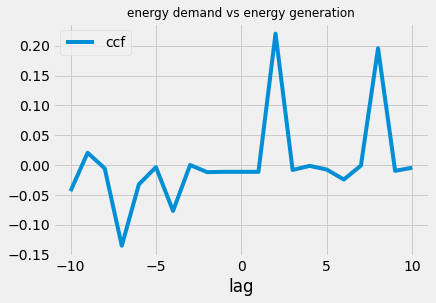

In [ ]:
cross_correlation('energy demand', 'energy generation', weekly_change, -10, 11)

#### Compare demand to price
We want to see how the actual energy price respond to the demand. Insights from this are useful to make decision in terms of the energy cost. For example, if the high demand correponds to higher energy prices, then we may want compare the cost of energy storage.

There are several things we need to check before going into the analysis for the `price actual` column:
* Zero values or the NA values
* Aggredate for the monthly price
* Standardize `price actual` and `energy demand` since they are in different scale

In [ ]:
energy[(energy['price actual'].isna()) | (energy['price actual'] == 0)]

,index,biomass,fossil brown coal/lignite,fossil coal-derived gas,fossil gas,fossil hard coal,fossil oil,fossil oil shale,fossil peat,geothermal,...,wind onshore,energy demand,price actual,Year,Year-Month,fossil_fuel,hydro,wind,others,energy generation
time,,,,,,,,,,,,,,,,,,,,,


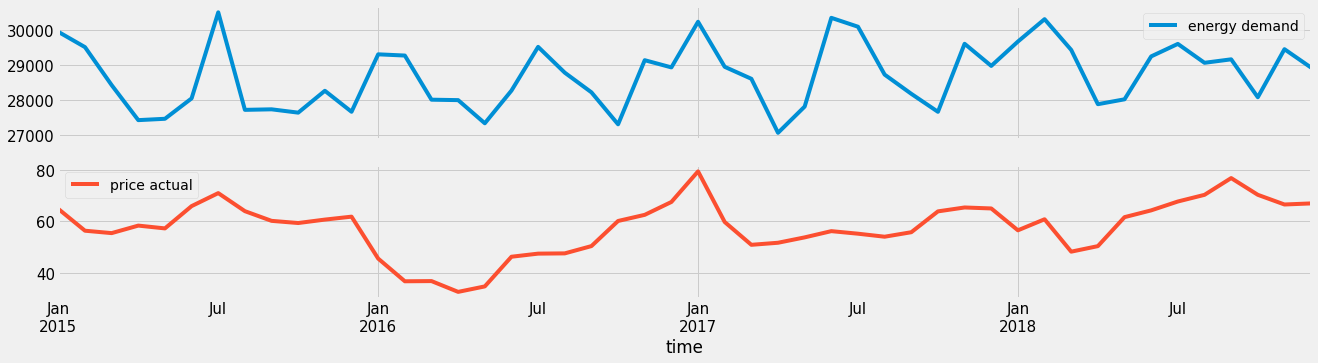

In [ ]:
monthly_demand[['energy demand', 'price actual']].plot(fontsize=15, subplots=True)
plt.gcf().set_size_inches(20, 5)
plt.legend()

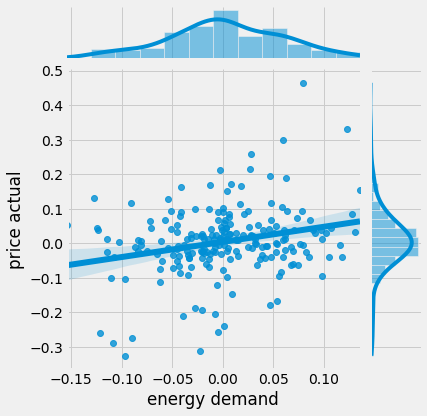

In [ ]:
weekly_demand = energy.resample('W-MON').mean()
w_demand_price = weekly_demand[['energy demand', 'price actual']]
weekly_change = w_demand_price.pct_change().dropna()
sns.jointplot(x='energy demand', y='price actual',data=weekly_change, kind="reg")

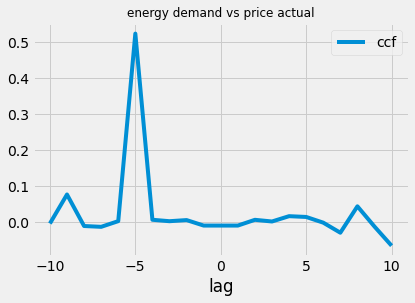

In [ ]:
cross_correlation('energy demand', 'price actual', weekly_change, -10, 11)

#### Cross-Correlation between Energy Sources
Earlier in this analysis, we identified some relationship between these energy sources from the time series plots. Now, we want to see the relationship between their lags using cross-correlation. Here is a list of pair of energy sources:
* `fossil_fuel` (nonrenewable) with other major renewable energy sources, such as `wind`, `hydro`, and `nuclear`
* Cross-correlation between renewable energy sources, such as `wind`, `hydro`, and `nuclear`

### Renewable vs Nonrenewable Energy Generation
We want to classify and aggregate energy in two categroies: renewable and nonrenewable. And compare the trend of both type of energy generation across time.

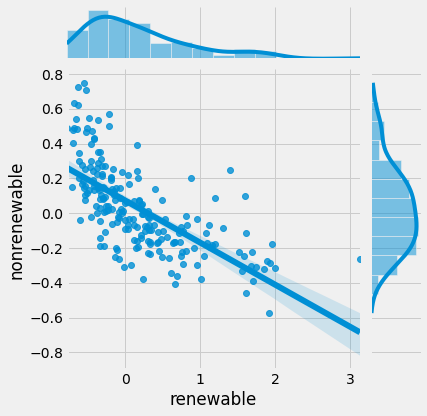

In [ ]:
renewable_list = ['biomass','hydro','wind','solar', 'waste']
nonrenewable_list = ['fossil_fuel','nuclear']
major_source = energy.loc[:,energy_list]
weekly_demand['renewable'] = major_source.loc[:, renewable_list].sum(axis=1)
weekly_demand['nonrenewable'] = major_source.loc[:, nonrenewable_list].sum(axis=1)

w_RN = weekly_demand[['renewable','nonrenewable']]
weekly_change = w_RN.pct_change().dropna()
sns.jointplot(x='renewable', y='nonrenewable',data=weekly_change, kind="reg")

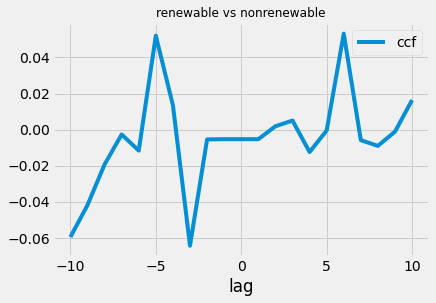

In [ ]:
cross_correlation('renewable', 'nonrenewable', weekly_change, -10, 11)

### Energy Production Forecasting

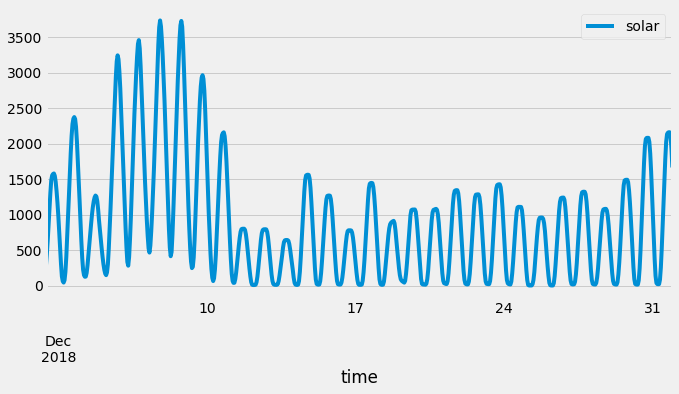

In [ ]:
last_year = energy.iloc[-720:]
last_year.loc[:,'solar'].rolling(window=12).mean().dropna().plot()
plt.gcf().set_size_inches(10, 5)
plt.legend(loc='best')

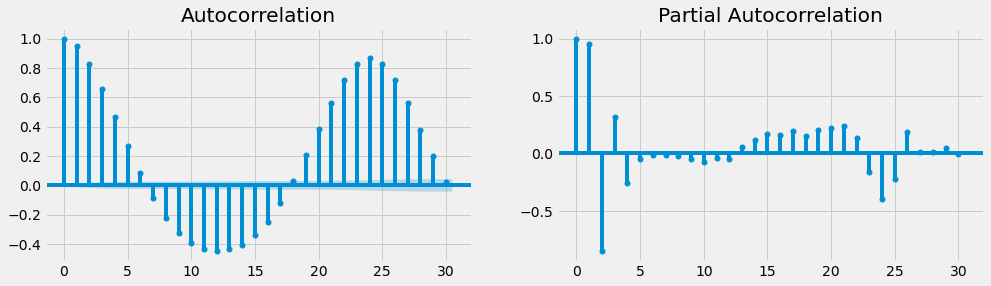

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(energy['solar'], lags=30, ax=axes[0])
fig = plot_pacf(energy['solar'], lags=30, ax=axes[1])

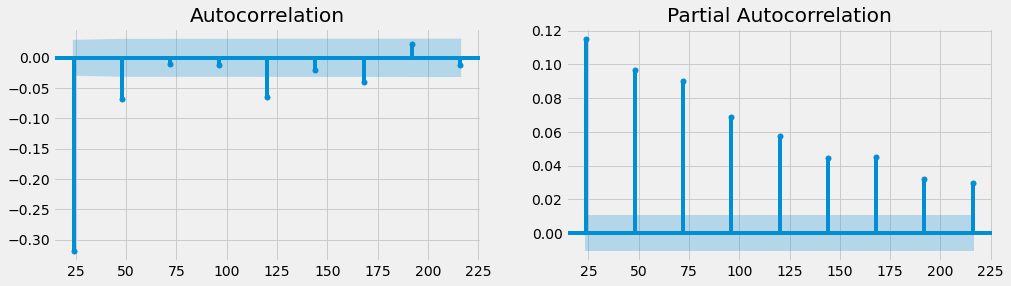

In [ ]:
solar_diff = energy['solar'].diff(24).dropna()
# Create figure
fig, axes = plt.subplots(1,2, figsize=(15, 4))
# Plot seasonal ACF
ACF = plot_acf(solar_diff,  lags=list(range(24,240,24)), ax=axes[0])
# Plot seasonal PACF
PACF = plot_pacf(solar_diff, lags=list(range(24,240,24)), ax=axes[1])

In [ ]:
energy = energy.asfreq('h')
order_aic_bic = []
for p in range(3):
    for P in range(3):
        try:            
            model = SARIMAX(energy['solar'].to_frame().iloc[-168:], order=(p,0,0),seasonal_order=(P,0,0,24))            
            results = model.fit()
            order_aic_bic.append((p, P, results.aic, results.bic))
        except:
            order_aic_bic.append((p, P, None, None))

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.


In [ ]:
order_df = pd.DataFrame(order_aic_bic, columns=['p','P','AIC','BIC'])
order_df.sort_values('AIC').head()

,p,P,AIC,BIC
7,2,1,2021.612272,2034.108128
8,2,2,2022.709148,2038.328968
5,1,2,2111.047078,2123.542934
4,1,1,2113.417008,2122.788900
6,2,0,2320.080882,2329.452773


In [ ]:
order_df.sort_values('BIC').head()

,p,P,AIC,BIC
7,2,1,2021.612272,2034.108128
8,2,2,2022.709148,2038.328968
4,1,1,2113.417008,2122.788900
5,1,2,2111.047078,2123.542934
6,2,0,2320.080882,2329.452773


In [ ]:
model = SARIMAX(energy['solar'].iloc[-720*12:], order=(2,0,0), seasonal_order=(1,0,0,24))
results = model.fit()

In [ ]:
print(results.summary())
forecast = results.get_forecast(steps=24)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

                                     SARIMAX Results                                      
Dep. Variable:                              solar   No. Observations:                 8640
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -57943.500
Date:                            Tue, 01 Jun 2021   AIC                         115895.001
Time:                                    21:03:39   BIC                         115923.257
Sample:                                01-05-2018   HQIC                        115904.635
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5731      0.004    440.663      0.000       1.566       1.580
ar.L2         -0.6418      0.004   

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


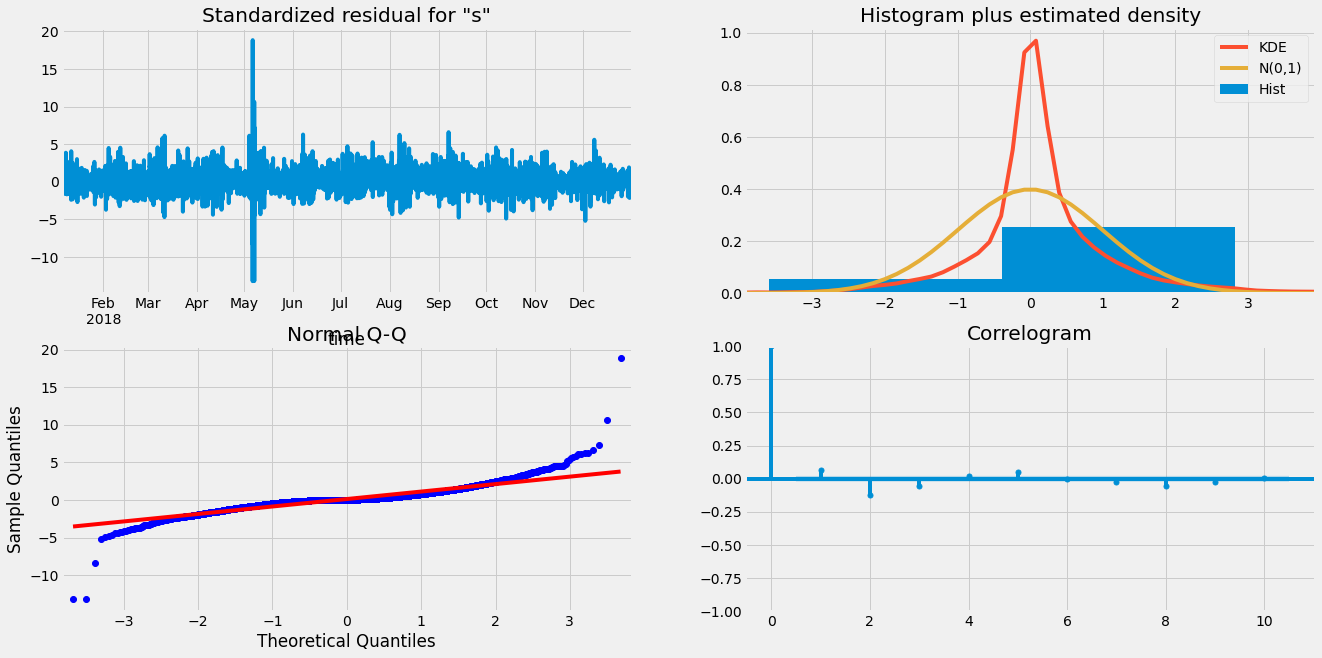

In [ ]:
X = results.plot_diagnostics()
plt.gcf().set_size_inches(20, 10)

Check the performance of the model
* train and test split

In [ ]:
train = energy['solar'].iloc[-720*12:-24].to_frame()
test = energy['solar'].iloc[-24:].to_frame()
train['month'] = train.index.month

In [ ]:
train.head()

,solar,month
time,,
2018-01-05 23:00:00+00:00,355.0,1
2018-01-06 00:00:00+00:00,302.0,1
2018-01-06 01:00:00+00:00,242.0,1
2018-01-06 02:00:00+00:00,231.0,1
2018-01-06 03:00:00+00:00,230.0,1


In [ ]:
hotEncodedMonth = pd.get_dummies(train['month'], prefix='month')
hotEncodedMonth.drop('month_1', axis= 1, inplace=True)
train.drop('month',axis=1, inplace=True)
train = pd.concat([train, hotEncodedMonth], axis=1)

In [ ]:
train.head()

,solar,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,
2018-01-05 23:00:00+00:00,355.0,0,0,0,0,0,0,0,0,0,0,0
2018-01-06 00:00:00+00:00,302.0,0,0,0,0,0,0,0,0,0,0,0
2018-01-06 01:00:00+00:00,242.0,0,0,0,0,0,0,0,0,0,0,0
2018-01-06 02:00:00+00:00,231.0,0,0,0,0,0,0,0,0,0,0,0
2018-01-06 03:00:00+00:00,230.0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.columns[1:]

Index(['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [ ]:
train['solar'].head()

time
2018-01-05 23:00:00+00:00    355.0
2018-01-06 00:00:00+00:00    302.0
2018-01-06 01:00:00+00:00    242.0
2018-01-06 02:00:00+00:00    231.0
2018-01-06 03:00:00+00:00    230.0
Freq: H, Name: solar, dtype: float64

In [ ]:
exog = sm.add_constant(train['solar'])
model = SARIMAX(train['solar'], order=(2,0,0), seasonal_order=(1,0,0,24), trend='c', exog=train[train.columns[1:]])
results = model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              solar   No. Observations:                 8616
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -57766.403
Date:                            Tue, 01 Jun 2021   AIC                         115564.806
Time:                                    21:06:55   BIC                         115677.788
Sample:                                01-05-2018   HQIC                        115603.334
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0737      4.664      0.445      0.657      -7.069      11.216
month_2     1245.7071     27.121     45.932      0.000    1192.552    1298.862
month_3     1350.5049    184.576      7.317      0.000     988.742    1712.267
month_4     1501.5835    221.502      6.779      0.000    1067.448    1935.719
month_5     1527.0136    236.594      6.454      0.000    1063.299    1990.728
month_6     1855.0949    236.953      7.829      0.000    1390.676    2319.513
month_7     2008.3582    241.707      8.309      0.000    1534.622    2482.094
month_8     1706.9540    243.717      7.004      0.000    1229.278    2184.630
month_9     1510.4892    250.644      6.026      0.000    1019.236    2001.743
month_10    1001.2024    251.786      3.976      0.000     507.712    1494.693
month_11     831.7347    289.448      2.874      0.004     264.426    1399.043
month_12     869.4883    395.304      2.200      0.028      94.707    1644.270
ar.L1          1.5823      0.004    437.093      0.000       1.575       1.589
ar.L2         -0.6639      0.004   -173.047      0.000      -0.671      -0.656
ar.S.L24       0.7133      0.003    220.770      0.000       0.707       0.720
sigma2      3.891e+04    206.652    188.265      0.000    3.85e+04    3.93e+04
===================================================================================
Ljung-Box (L1) (Q):                  41.73   Jarque-Bera (JB):            256675.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = results.get_prediction()
mean_prediction = prediction.predicted_mean
mean_prediction

time
2018-01-05 23:00:00+00:00     88.622841
2018-01-06 00:00:00+00:00    341.824282
2018-01-06 01:00:00+00:00    248.901103
2018-01-06 02:00:00+00:00    188.956830
2018-01-06 03:00:00+00:00    211.169992
                                ...    
2018-12-30 18:00:00+00:00   -191.040963
2018-12-30 19:00:00+00:00    -17.354529
2018-12-30 20:00:00+00:00     46.986766
2018-12-30 21:00:00+00:00     50.309573
2018-12-30 22:00:00+00:00     55.550506
Freq: H, Name: predicted_mean, Length: 8616, dtype: float64

In [ ]:
# residual = train - mean_prediction
# residual.rolling(window=24*7).mean().plot()

<AxesSubplot:xlabel='time'>

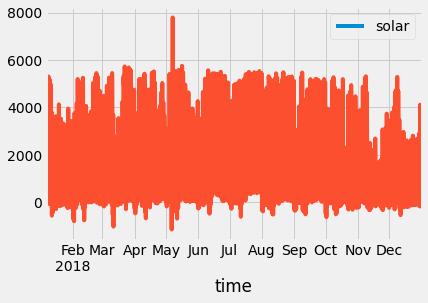

In [ ]:
test.plot()
mean_prediction.plot()

(array([17896.  , 17896.25, 17896.5 , 17896.75, 17897.  , 17897.25,
        17897.5 , 17897.75, 17898.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

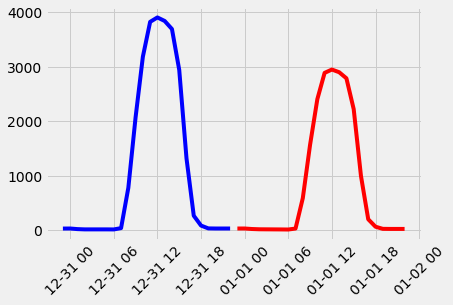

In [ ]:
plt.plot(test.index, test.values, color='blue', label='data')
# Plot prediction
plt.plot(mean_forecast.index,mean_forecast.values,color='red',label='forecast')
# Shade uncertainty area
# plt.fill_between(mean_forecast.index, conf_int['lower solar'], conf_int['upper solar'], color='pink')
plt.xticks(rotation=45)

In [ ]:
mae = np.mean(np.abs(test - mean_forecast))
print(mae)

2018-12-31 23:00:00+00:00   NaN
2019-01-01 00:00:00+00:00   NaN
2019-01-01 01:00:00+00:00   NaN
2019-01-01 02:00:00+00:00   NaN
2019-01-01 03:00:00+00:00   NaN
2019-01-01 04:00:00+00:00   NaN
2019-01-01 05:00:00+00:00   NaN
2019-01-01 06:00:00+00:00   NaN
2019-01-01 07:00:00+00:00   NaN
2019-01-01 08:00:00+00:00   NaN
2019-01-01 09:00:00+00:00   NaN
2019-01-01 10:00:00+00:00   NaN
2019-01-01 11:00:00+00:00   NaN
2019-01-01 12:00:00+00:00   NaN
2019-01-01 13:00:00+00:00   NaN
2019-01-01 14:00:00+00:00   NaN
2019-01-01 15:00:00+00:00   NaN
2019-01-01 16:00:00+00:00   NaN
2019-01-01 17:00:00+00:00   NaN
2019-01-01 18:00:00+00:00   NaN
2019-01-01 19:00:00+00:00   NaN
2019-01-01 20:00:00+00:00   NaN
2019-01-01 21:00:00+00:00   NaN
2019-01-01 22:00:00+00:00   NaN
solar                       NaN
dtype: float64


In [ ]:
energy['solar'].head()

time
2015-01-01 00:00:00+00:00    50.0
2015-01-01 01:00:00+00:00    50.0
2015-01-01 02:00:00+00:00    50.0
2015-01-01 03:00:00+00:00    42.0
2015-01-01 04:00:00+00:00    34.0
Freq: H, Name: solar, dtype: float64

In [ ]:
results = pm.auto_arima(energy['solar'][-720:], d= 0, start_p=0, max_p=3, 
    start_q=0, max_q=0, seasonal=True, m=24, D=0, start_P=0, max_P=3, start_Q=0, max_Q=0)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 24)   Log Likelihood               -4589.984
Date:                            Tue, 01 Jun 2021   AIC                           9191.968
Time:                                    21:13:12   BIC                           9219.443
Sample:                                         0   HQIC                          9202.575
                                            - 720                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.0329      5.704      2.986      0.003       5.853      28.213
ar.L1          1.7106      0.024     71.262      0.000       1.664       1.758
ar.L2         -0.9739      0.045    -21.851      0.000      -1.061      -0.887
ar.L3          0.1784      0.028      6.394      0.000       0.124       0.233
ar.S.L24       0.7736      0.018     43.092      0.000       0.738       0.809
sigma2      1.947e+04    488.822     39.836      0.000    1.85e+04    2.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):              2160.80
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
results

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 24),
      suppress_warnings=True)

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


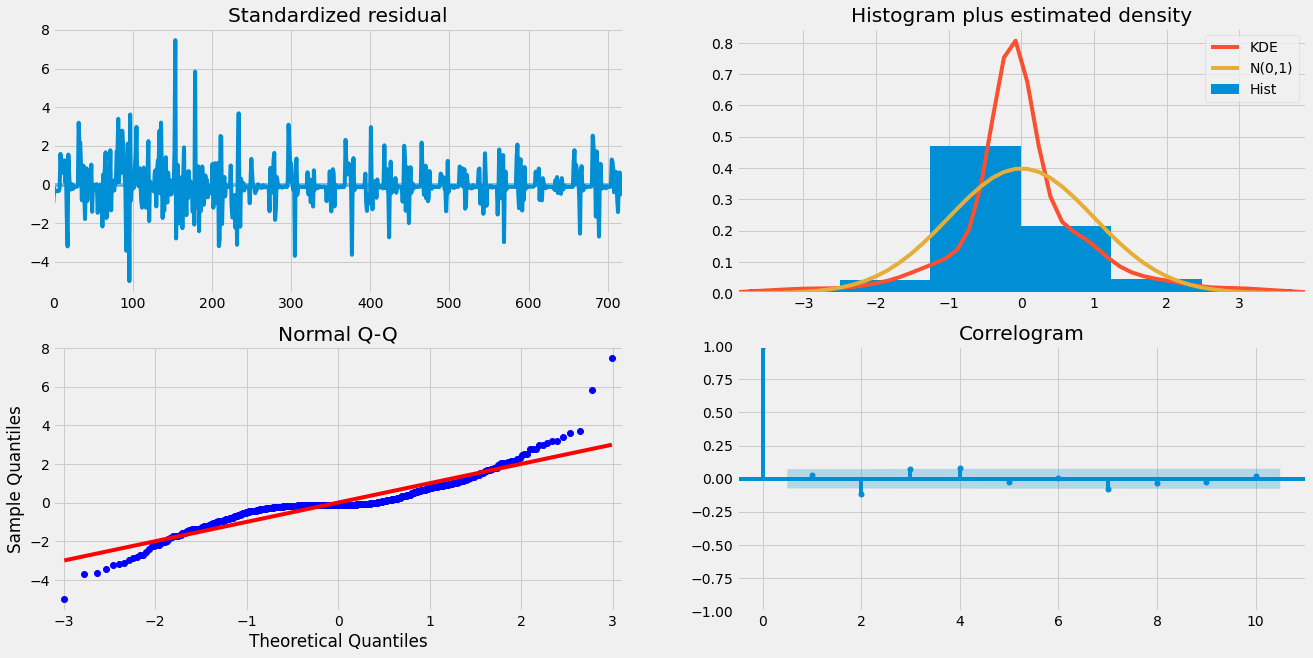

In [ ]:
X = results.plot_diagnostics()
plt.gcf().set_size_inches(20, 10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1638dc94-e6d7-43b6-8bef-1d6183fef075' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>